In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini")


In [32]:
from pydantic import BaseModel
from typing import List, Annotated, TypedDict
from operator import add

class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, add]
    best_joke_selected: str

In [33]:
class subjects(BaseModel):
    subjects: List[str]

def generate_subjects(state: OverallState):
    """
    
    Node to generate subjects for the topic given by the user
    
    """
    print("---------------GENERATE SUBJECTS NODE---------------")
    topic = state["topic"]

    subjects_prompt = f"Generate 5 subjects for the topic: {topic}"
    formatted_subject_prompt = subjects_prompt.format(topic=topic)
    
    llm_strcutured_output = llm.with_structured_output(subjects)

    response = llm_strcutured_output.invoke(formatted_subject_prompt)
    
    print(f"Generated subjects: {response.subjects}")

    return {"subjects": response.subjects}


## Map reduce - 
Spawn multiple generate joke nodes for each subject

In [42]:
from langgraph.constants import Send


def continue_to_jokes(state: OverallState):
    """
    Spawn multiple generate joke nodes for each subject
    """
    print("---------------CONTINUE TO JOKES NODE---------------")
    return [Send("generate_joke", {"subject": subject}) for subject in state["subjects"]]

class GenerateJokeInput(BaseModel):
    subject: str

class GenerateJokeOutput(BaseModel):
    joke: str


def generate_joke(state: GenerateJokeInput) -> GenerateJokeOutput:
    """
    Generate a joke for the subject
    """
    print("---------------GENERATE JOKE NODE---------------")
    subject = state["subject"]

    joke_prompt = f"Generate a joke about the subject: {subject}"
    formatted_joke_prompt = joke_prompt.format(subject=subject)

    llm_strcutured_output = llm.with_structured_output(GenerateJokeOutput)

    response = llm_strcutured_output.invoke(formatted_joke_prompt)

    print(f"Subject: {subject} \n Generated joke: {response.joke}")

    return {"jokes": [response.joke]}


In [50]:
class BestJoke(BaseModel):
    id:int

def best_joke(state: OverallState):
    """
    Node to find the best joke
    """
    print("---------------BEST JOKE NODE---------------")
    jokes = "\n\n".join(joke for joke in state["jokes"])
    
    best_joke_prompt = f"Find the best joke from the following jokes: {jokes}"

    llm_strcutured_output = llm.with_structured_output(BestJoke)

    response = llm_strcutured_output.invoke(best_joke_prompt)

    print(f"Jokes: {jokes} \n Best joke: {state['jokes'][response.id]}")

    return {"best_joke_selected": state["jokes"][response.id]}

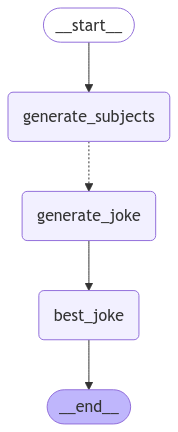

In [53]:
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END


builder = StateGraph(OverallState)

builder.add_node("generate_subjects", generate_subjects)
builder.add_node("generate_joke", generate_joke)
builder.add_node("best_joke", best_joke)

builder.add_edge(START, "generate_subjects")
builder.add_conditional_edges("generate_subjects", continue_to_jokes, ["generate_joke"])
builder.add_edge("generate_joke", "best_joke")
builder.add_edge("best_joke", END)

builder.compile()

graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [52]:
for event in graph.stream({"topic": "AI"}):
    print(event)

---------------GENERATE SUBJECTS NODE---------------
Generated subjects: ['Machine Learning', 'Natural Language Processing', 'Computer Vision', 'Ethics in AI', 'AI in Healthcare']
---------------CONTINUE TO JOKES NODE---------------
{'generate_subjects': {'subjects': ['Machine Learning', 'Natural Language Processing', 'Computer Vision', 'Ethics in AI', 'AI in Healthcare']}}
---------------GENERATE JOKE NODE---------------
---------------GENERATE JOKE NODE---------------
---------------GENERATE JOKE NODE---------------
---------------GENERATE JOKE NODE---------------
---------------GENERATE JOKE NODE---------------
Subject: Natural Language Processing 
 Generated joke: Why did the natural language processing model break up with its girlfriend? Because it couldn't parse her emotions!
{'generate_joke': {'jokes': ["Why did the natural language processing model break up with its girlfriend? Because it couldn't parse her emotions!"]}}
Subject: Ethics in AI 
 Generated joke: Why did the AI cr